In [33]:
import tensorflow
from tensorflow import keras
import keras.layers as layer
import keras.optimizers as opt
import keras.losses as loss
import keras.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Preparing the Data

In [11]:
pathBreast = "data/Multi Cancer/Breast Cancer/"
print(os.listdir(pathBreast + "breast_benign"))

['breast_benign_0001.jpg', 'breast_benign_0002.jpg', 'breast_benign_0003.jpg', 'breast_benign_0004.jpg', 'breast_benign_0005.jpg', 'breast_benign_0006.jpg', 'breast_benign_0007.jpg', 'breast_benign_0008.jpg', 'breast_benign_0009.jpg', 'breast_benign_0010.jpg', 'breast_benign_0011.jpg', 'breast_benign_0012.jpg', 'breast_benign_0013.jpg', 'breast_benign_0014.jpg', 'breast_benign_0015.jpg', 'breast_benign_0016.jpg', 'breast_benign_0017.jpg', 'breast_benign_0018.jpg', 'breast_benign_0019.jpg', 'breast_benign_0020.jpg', 'breast_benign_0021.jpg', 'breast_benign_0022.jpg', 'breast_benign_0023.jpg', 'breast_benign_0024.jpg', 'breast_benign_0025.jpg', 'breast_benign_0026.jpg', 'breast_benign_0027.jpg', 'breast_benign_0028.jpg', 'breast_benign_0029.jpg', 'breast_benign_0030.jpg', 'breast_benign_0031.jpg', 'breast_benign_0032.jpg', 'breast_benign_0033.jpg', 'breast_benign_0034.jpg', 'breast_benign_0035.jpg', 'breast_benign_0036.jpg', 'breast_benign_0037.jpg', 'breast_benign_0038.jpg', 'breast_ben

In [12]:
callbakcs = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto",
    restore_best_weights=True
)

In [34]:
pathBreast = "data/Multi Cancer/Breast Cancer/"

images, labels = [], []
paths = []
for category in os.listdir(pathBreast):
    for filename in os.listdir(pathBreast + category):
        img = cv2.imread(os.path.join(pathBreast + category, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (192, 192))
        if img is not None:
            images.append(img)
            labels.append(1 if category.split('_')[1] == "benign" else 0)

images = np.array(images)
labels = np.array(labels)
x_train, x_test_val_data, y_train, y_test_val_data = train_test_split(images, labels, test_size = 0.4, random_state=42, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test_val_data, y_test_val_data, test_size = 0.5, random_state=69, shuffle=True)

In [35]:
# Preprocessing:
# normalize input
x_train = x_train - np.mean(x_train, axis = 0)
x_train /= np.std(x_train, axis=0)

x_test = x_test - np.mean(x_test, axis=0)
x_test /= np.std(x_test, axis=0)

x_val = x_val - np.mean(x_val, axis=0)
x_val /= np.std(x_val, axis=0)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)
y_val = keras.utils.to_categorical(y_val, 2)

# Data Augmentation

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by up to 20 degrees.
    width_shift_range=0.2,  # Randomly shift the width of the image.
    height_shift_range=0.2,  # Randomly shift the height of the image.
    shear_range=0.2,  # Apply shear transformation.
    zoom_range=0.2,  # Randomly zoom in/out.
    horizontal_flip=True,  # Randomly flip the image horizontally.
    vertical_flip=True,  # Randomly flip the image vertically.
    fill_mode='nearest'  # Fill in missing pixels using the nearest available value.
)
print(len(x_train))
augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    img = x_train[i]
    label = y_train[i]
    num_augmented_samples = 1  # You can change this number as needed.

    for j in range(num_augmented_samples):
        augmented_img = datagen.random_transform(img)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Append the augmented data to the original data
x_train = np.append(x_train, augmented_images, axis=0)
y_train = np.append(y_train, augmented_labels, axis=0)

6000


In [7]:
print(len(x_train))

12000


# Model 

In [8]:
#STEM Network
cancer_inception_inputs = layer.Input(shape=(192, 192,3))
conv1 = layer.Conv2D(64,(7,7),strides=2, padding="same", activation="elu")(cancer_inception_inputs)
bn1 = layer.BatchNormalization()(conv1)
mxPool1 = layer.MaxPool2D((3,3),strides=2)(bn1)
conv2 = layer.Conv2D(64, (1,1), activation="elu")(mxPool1)
bn2 = layer.BatchNormalization()(conv2)
conv3 = layer.Conv2D(192, (3,3), padding="same", activation="elu")(bn2)
bn3 = layer.BatchNormalization()(conv3)
mxPool2 = layer.MaxPool2D((3,3),strides=2, padding="same")(bn3)

#Inception Block
conv2_1 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
conv2_2 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
mxPool2_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(mxPool2)
bn2_1 = layer.BatchNormalization()(conv2_1)
bn2_2 = layer.BatchNormalization()(conv2_2)
# Second Layer in Inception Block
conv2_3 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
conv2_4 = layer.Conv2D(128,(3,3), padding="same", activation="elu")(bn2_1)
conv2_5 = layer.Conv2D(32, (5,5), padding = "same", activation="elu")(bn2_2)
conv2_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2_1)
bn2_3 = layer.BatchNormalization()(conv2_3)
bn2_4 = layer.BatchNormalization()(conv2_4)
bn2_5 = layer.BatchNormalization()(conv2_5)
bn2_6 = layer.BatchNormalization()(conv2_6)
conc2 = layer.Concatenate()([bn2_3,bn2_4,bn2_5,bn2_6])

#Second Inception Block
conv3_1 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv3_2 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
mxPool3_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(conc2)
bn3_1 = layer.BatchNormalization()(conv3_1)
bn3_2 = layer.BatchNormalization()(conv3_2)
# Second Layer In Second Inception Block
conv3_3 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv3_4 = layer.Conv2D(192,(3,3), padding="same", activation="elu")(bn3_1)
conv3_5 = layer.Conv2D(64, (5,5), padding = "same", activation="elu")(bn3_2)
conv3_6 = layer.Conv2D(96,(1,1), activation="elu")(mxPool3_1)
bn3_3 = layer.BatchNormalization()(conv3_3)
bn3_4 = layer.BatchNormalization()(conv3_4)
bn3_5 = layer.BatchNormalization()(conv3_5)
bn3_6 = layer.BatchNormalization()(conv3_6)
conc3 = layer.Concatenate()([bn3_3,bn3_4,bn3_5,bn3_6])

gAvg = layer.AveragePooling2D((5,5), strides=3)(conc3)
conv4_1 = layer.Conv2D(128,(1,1), activation="elu")(gAvg)
bn4_1 = layer.BatchNormalization()(conv4_1)
net_out = layer.Flatten()(bn4_1)
fc1 = layer.Dense(1028, activation="elu")(net_out)
cancer_output = layer.Dense(2, activation="softmax")(fc1)

cancer_model = Model(cancer_inception_inputs, cancer_output)
cancer_model.compile(optimizer=opt.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
cancer_model_hist = cancer_model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=[callbakcs], verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
47/47 [==============================] - 429s 8s/step - loss: 20.4110 - accuracy: 0.7585 - val_loss: 28264.2520 - val_accuracy: 0.5025
Epoch 2/100
47/47 [==============================] - 369s 8s/step - loss: 1.0321 - accuracy: 0.8372 - val_loss: 2146.1035 - val_accuracy: 0.5110
Epoch 3/100
47/47 [==============================] - 365s 8s/step - loss: 0.6851 - accuracy: 0.8540 - val_loss: 123.7825 - val_accuracy: 0.6455
Epoch 4/100
47/47 [==============================] - 365s 8s/step - loss: 0.3494 - accuracy: 0.8809 - val_loss: 5.4168 - val_accuracy: 0.8420
Epoch 5/100
47/47 [==============================] - 369s 8s/step - loss: 0.2715 - accuracy: 0.9004 - val_loss: 0.3703 - val_accuracy: 0.8725
Epoch 6/100
47/47 [==============================] - 365s 8s/step - loss: 0.2082 - accuracy: 0.9161 - val_loss: 0.2309 - val_accuracy: 0.9130
Epoch 7/100
47/47 [==============================] - 365s 8s/step - loss: 0.1708 - accuracy: 0.9279 - val_loss: 0.1593 - val_accuracy: 0.9

In [14]:
score = cancer_model.evaluate(x_test, y_test, batch_size=256)
print(score[0])
print(score[1])

8/8 [==============================] - 14s 2s/step - loss: 0.0586 - accuracy: 0.9780
0.058648090809583664
0.9779999852180481


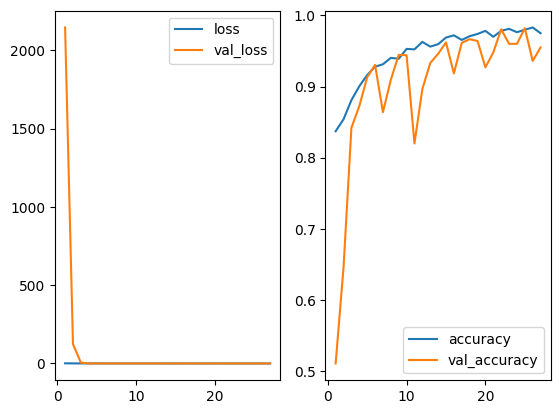

In [15]:
plt.subplot(1, 2, 1)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['loss'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_loss'][1:])
plt.legend(['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['accuracy'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_accuracy'][1:])
plt.legend(['accuracy', 'val_accuracy'])

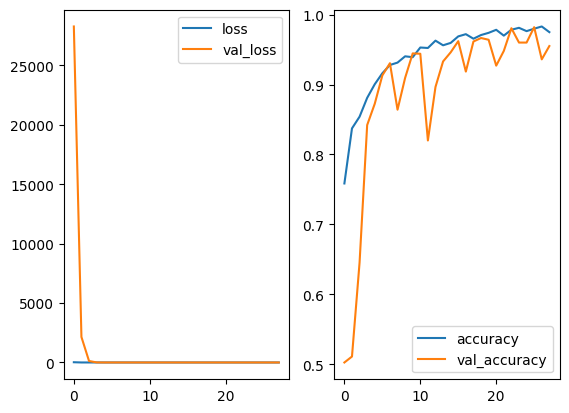

In [16]:
plt.subplot(1, 2, 1)
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['loss'])
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['accuracy'])
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [17]:
cancer_model.save('models/inceptionV4_part1V2.keras')

# Second Part of the Model

In [10]:
# Load the saved model
cancerModel1 = keras.models.load_model('models/inceptionV4_part1V2.keras')

checkpoint1 = 'concatenate_1'


# Third Inception Block
#print("Layer Output Shape:", cancerModel1.get_layer(checkpoint1).output_shape)

conv4_1 = keras.layers.Conv2D(192,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
conv4_2 = keras.layers.Conv2D(192,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
bn4_1 = layer.BatchNormalization()(conv4_1)
bn4_2 = layer.BatchNormalization()(conv4_2)
mxPool4_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(cancerModel1.get_layer(checkpoint1).output)

#print("conv4_1 Output Shape:", conv4_1.shape)
#print("conv4_2 Output Shape:", conv4_2.shape)
#print("mxPool4_1 Output Shape:", mxPool4_1.shape)


# Second Layer in Third Inception Block
conv4_3 = keras.layers.Conv2D(192,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
conv4_4 = keras.layers.Conv2D(96,(3,3), padding="same", activation="elu")(bn4_1)
conv4_5 = keras.layers.Conv2D(16, (5,5), padding = "same", activation="elu")(bn4_2)
conv4_6 = keras.layers.Conv2D(64,(1,1), activation="elu")(mxPool4_1)
bn4_3 = layer.BatchNormalization()(conv4_3)
bn4_4 = layer.BatchNormalization()(conv4_4)
bn4_5 = layer.BatchNormalization()(conv4_5)
bn4_6 = layer.BatchNormalization()(conv4_6)
conc4 = keras.layers.Concatenate()([bn4_3,bn4_4,bn4_5,bn4_6])
#print("conv4_3 Output Shape:", conv4_3.shape)
#print("conv4_4 Output Shape:", conv4_4.shape)
#print("conv4_5 Output Shape:", conv4_5.shape)
#print("conv4_6 Output Shape:", conv4_6.shape)
#print("conc4 Output Shape:", conc4.shape)


# Fourth Inception Block
conv5_1 = keras.layers.Conv2D(160,(1,1), activation="elu")(conc4)
conv5_2 = keras.layers.Conv2D(160,(1,1), activation="elu")(conc4)
bn5_1 = layer.BatchNormalization()(conv5_1)
bn5_2 = layer.BatchNormalization()(conv5_2)
mxPool5_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(conc4)

#print("conv5_1 Output Shape:", conv5_1.shape)
#print("conv5_2 Output Shape:", conv5_2.shape)
#print("mxPool5_1 Output Shape:", mxPool5_1.shape)


# Second Layer In Fourth Inception Block
conv5_3 = keras.layers.Conv2D(160,(1,1), activation="elu")(conc4)
conv5_4 = keras.layers.Conv2D(112,(3,3), padding="same", activation="elu")(bn5_1)
conv5_5 = keras.layers.Conv2D(24, (5,5), padding = "same", activation="elu")(bn5_2)
conv5_6 = keras.layers.Conv2D(64,(1,1), activation="elu")(mxPool5_1)
bn5_3 = layer.BatchNormalization()(conv5_3)
bn5_4 = layer.BatchNormalization()(conv5_4)
bn5_5 = layer.BatchNormalization()(conv5_5)
bn5_6 = layer.BatchNormalization()(conv5_6)
conc5 = keras.layers.Concatenate()([bn5_3,bn5_4,bn5_5,bn5_6])
#print("conv5_3 Output Shape:", conv5_3.shape)
#print("conv5_4 Output Shape:", conv5_4.shape)
#print("conv5_5 Output Shape:", conv5_5.shape)
#print("conv5_6 Output Shape:", conv5_6.shape)
#print("conc5 Output Shape:", conc5.shape)


gAvg = keras.layers.AveragePooling2D((5,5), strides=3)(conc5)
conv6_1 = keras.layers.Conv2D(64,(1,1), activation="elu")(gAvg)
bn6_1 = layer.BatchNormalization()(conv6_1)
net_out = keras.layers.Flatten()(bn6_1)
fc1 = keras.layers.Dense(1028, activation="elu")(net_out)
cancer_output_2 = keras.layers.Dense(2, activation="softmax")(fc1)
#print("gAvg Output Shape:", gAvg.shape)
#print("conv6_1 Output Shape:", conv6_1.shape)
#print("net_out Output Shape:", net_out.shape)
#print("fc1 Output Shape:", fc1.shape)
#print("cancer_output_2 Output Shape:", cancer_output_2.shape)


cancer_model_2_together = Model(inputs=cancerModel1.input, outputs=cancer_output_2)
cancer_model_2_together.compile(optimizer=opt.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
cancer_model_2_together.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [11]:
cancer_model_2_together_hist = cancer_model_2_together.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=[callbakcs], verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
47/47 [==============================] - 727s 15s/step - loss: 13.5964 - accuracy: 0.7625 - val_loss: 27201.1973 - val_accuracy: 0.4755
Epoch 2/100
47/47 [==============================] - 658s 14s/step - loss: 1.0538 - accuracy: 0.8253 - val_loss: 219.2698 - val_accuracy: 0.6060
Epoch 3/100
47/47 [==============================] - 648s 14s/step - loss: 0.2738 - accuracy: 0.8826 - val_loss: 11.8235 - val_accuracy: 0.7340
Epoch 4/100
47/47 [==============================] - 679s 14s/step - loss: 0.2126 - accuracy: 0.9051 - val_loss: 2.6678 - val_accuracy: 0.7515
Epoch 5/100
47/47 [==============================] - 661s 14s/step - loss: 0.1988 - accuracy: 0.9135 - val_loss: 1.0163 - val_accuracy: 0.8340
Epoch 6/100
47/47 [==============================] - 687s 15s/step - loss: 0.1777 - accuracy: 0.9225 - val_loss: 0.3559 - val_accuracy: 0.8950
Epoch 7/100
47/47 [==============================] - 695s 15s/step - loss: 0.1665 - accuracy: 0.9293 - val_loss: 0.1935 - val_accuracy

In [12]:
score = cancer_model_2_together.evaluate(x_test, y_test, batch_size=256)
print(score[0])
print(score[1])

8/8 [==============================] - 22s 3s/step - loss: 0.0473 - accuracy: 0.9795
0.04729227349162102
0.9794999957084656


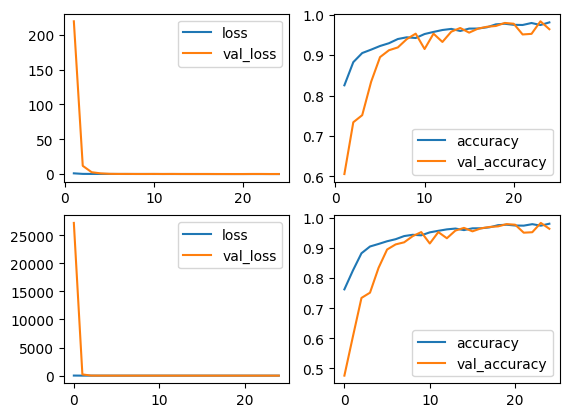

In [13]:
plt.subplot(2, 2, 1)
plt.plot(cancer_model_2_together_hist.epoch[1:], cancer_model_2_together_hist.history['loss'][1:])
plt.plot(cancer_model_2_together_hist.epoch[1:], cancer_model_2_together_hist.history['val_loss'][1:])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 2)
plt.plot(cancer_model_2_together_hist.epoch[1:], cancer_model_2_together_hist.history['accuracy'][1:])
plt.plot(cancer_model_2_together_hist.epoch[1:], cancer_model_2_together_hist.history['val_accuracy'][1:])
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(2, 2, 3)
plt.plot(cancer_model_2_together_hist.epoch, cancer_model_2_together_hist.history['loss'])
plt.plot(cancer_model_2_together_hist.epoch, cancer_model_2_together_hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 4)
plt.plot(cancer_model_2_together_hist.epoch, cancer_model_2_together_hist.history['accuracy'])
plt.plot(cancer_model_2_together_hist.epoch, cancer_model_2_together_hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [ ]:
cancer_model_2_together.save('models/inceptionV4_part2.keras')

# Model Part 1 with 3 inception blocks

In [8]:
#STEM Network
cancer_inception_inputs = layer.Input(shape=(192, 192,3))
conv1 = layer.Conv2D(64,(7,7),strides=2, padding="same", activation="elu")(cancer_inception_inputs)
bn1 = layer.BatchNormalization()(conv1)
mxPool1 = layer.MaxPool2D((3,3),strides=2)(bn1)
conv2 = layer.Conv2D(64, (1,1), activation="elu")(mxPool1)
bn2 = layer.BatchNormalization()(conv2)
conv3 = layer.Conv2D(192, (3,3), padding="same", activation="elu")(bn2)
bn3 = layer.BatchNormalization()(conv3)
mxPool2 = layer.MaxPool2D((3,3),strides=2, padding="same")(bn3)

#Inception Block
conv2_1 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
conv2_2 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
mxPool2_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(mxPool2)
bn2_1 = layer.BatchNormalization()(conv2_1)
bn2_2 = layer.BatchNormalization()(conv2_2)
# Second Layer in Inception Block
conv2_3 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
conv2_4 = layer.Conv2D(128,(3,3), padding="same", activation="elu")(bn2_1)
conv2_5 = layer.Conv2D(32, (5,5), padding = "same", activation="elu")(bn2_2)
conv2_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2_1)
bn2_3 = layer.BatchNormalization()(conv2_3)
bn2_4 = layer.BatchNormalization()(conv2_4)
bn2_5 = layer.BatchNormalization()(conv2_5)
bn2_6 = layer.BatchNormalization()(conv2_6)
conc2 = layer.Concatenate()([bn2_3,bn2_4,bn2_5,bn2_6])

#Second Inception Block
conv3_1 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv3_2 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
mxPool3_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(conc2)
bn3_1 = layer.BatchNormalization()(conv3_1)
bn3_2 = layer.BatchNormalization()(conv3_2)
# Second Layer In Second Inception Block
conv3_3 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv3_4 = layer.Conv2D(192,(3,3), padding="same", activation="elu")(bn3_1)
conv3_5 = layer.Conv2D(64, (5,5), padding = "same", activation="elu")(bn3_2)
conv3_6 = layer.Conv2D(96,(1,1), activation="elu")(mxPool3_1)
bn3_3 = layer.BatchNormalization()(conv3_3)
bn3_4 = layer.BatchNormalization()(conv3_4)
bn3_5 = layer.BatchNormalization()(conv3_5)
bn3_6 = layer.BatchNormalization()(conv3_6)
conc3 = layer.Concatenate()([bn3_3,bn3_4,bn3_5,bn3_6])

conv4_1 = keras.layers.Conv2D(192,(1,1), activation="elu")(conc3)
conv4_2 = keras.layers.Conv2D(192,(1,1), activation="elu")(conc3)
bn4_1 = layer.BatchNormalization()(conv4_1)
bn4_2 = layer.BatchNormalization()(conv4_2)
mxPool4_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(conc3)
# Second Layer in Third Inception Block
conv4_3 = keras.layers.Conv2D(192,(1,1), activation="elu")(conc3)
conv4_4 = keras.layers.Conv2D(96,(3,3), padding="same", activation="elu")(bn4_1)
conv4_5 = keras.layers.Conv2D(16, (5,5), padding = "same", activation="elu")(bn4_2)
conv4_6 = keras.layers.Conv2D(64,(1,1), activation="elu")(mxPool4_1)
bn4_3 = layer.BatchNormalization()(conv4_3)
bn4_4 = layer.BatchNormalization()(conv4_4)
bn4_5 = layer.BatchNormalization()(conv4_5)
bn4_6 = layer.BatchNormalization()(conv4_6)
conc4 = keras.layers.Concatenate()([bn4_3,bn4_4,bn4_5,bn4_6])

gAvg = layer.AveragePooling2D((5,5), strides=3)(conc4)
conv5_1 = layer.Conv2D(128,(1,1), activation="elu")(gAvg)
bn5_1 = layer.BatchNormalization()(conv5_1)
net_out = layer.Flatten()(bn5_1)
fc1 = layer.Dense(1028, activation="elu")(net_out)
cancer_output = layer.Dense(2, activation="softmax")(fc1)

cancer_model_3blocks = Model(cancer_inception_inputs, cancer_output)
cancer_model_3blocks.compile(optimizer=opt.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
cancer_model_3blocks_hist = cancer_model_3blocks.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=[callbakcs], verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
47/47 [==============================] - 619s 12s/step - loss: 20.8216 - accuracy: 0.7370 - val_loss: 4291.4634 - val_accuracy: 0.5025
Epoch 2/100
47/47 [==============================] - 549s 12s/step - loss: 0.7451 - accuracy: 0.8397 - val_loss: 388.3746 - val_accuracy: 0.5300
Epoch 3/100
47/47 [==============================] - 537s 11s/step - loss: 0.3070 - accuracy: 0.8828 - val_loss: 21.8874 - val_accuracy: 0.6830
Epoch 4/100
47/47 [==============================] - 530s 11s/step - loss: 0.2921 - accuracy: 0.8916 - val_loss: 1.9167 - val_accuracy: 0.8255
Epoch 5/100
47/47 [==============================] - 534s 11s/step - loss: 0.2392 - accuracy: 0.9051 - val_loss: 0.4868 - val_accuracy: 0.8335
Epoch 6/100
47/47 [==============================] - 527s 11s/step - loss: 0.2095 - accuracy: 0.9129 - val_loss: 0.2893 - val_accuracy: 0.8845
Epoch 7/100
47/47 [==============================] - 526s 11s/step - loss: 0.1978 - accuracy: 0.9182 - val_loss: 0.2171 - val_accuracy:

In [10]:
score = cancer_model_3blocks.evaluate(x_test, y_test, batch_size=256)
print(score[0])
print(score[1])

8/8 [==============================] - 17s 2s/step - loss: 0.0908 - accuracy: 0.9640
0.09082812070846558
0.9639999866485596


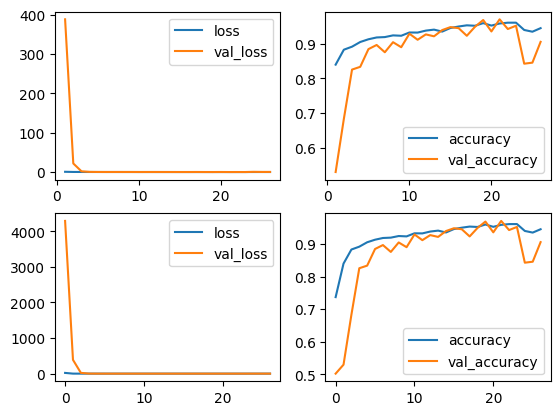

In [15]:
plt.subplot(2, 2, 1)
plt.plot(cancer_model_3blocks_hist.epoch[1:], cancer_model_3blocks_hist.history['loss'][1:])
plt.plot(cancer_model_3blocks_hist.epoch[1:], cancer_model_3blocks_hist.history['val_loss'][1:])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 2)
plt.plot(cancer_model_3blocks_hist.epoch[1:], cancer_model_3blocks_hist.history['accuracy'][1:])
plt.plot(cancer_model_3blocks_hist.epoch[1:], cancer_model_3blocks_hist.history['val_accuracy'][1:])
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(2, 2, 3)
plt.plot(cancer_model_3blocks_hist.epoch, cancer_model_3blocks_hist.history['loss'])
plt.plot(cancer_model_3blocks_hist.epoch, cancer_model_3blocks_hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 4)
plt.plot(cancer_model_3blocks_hist.epoch, cancer_model_3blocks_hist.history['accuracy'])
plt.plot(cancer_model_3blocks_hist.epoch, cancer_model_3blocks_hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [13]:
cancer_model_3blocks.save('models/inceptionV4_part1_3blocks.keras')

# Validating on BreakHIS

In [29]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/"

images, labels = [], []
for cancerType in os.listdir(pathBenign):
    for cancerVariant in os.listdir(pathBenign + cancerType):
        for zoom in os.listdir(pathBenign + cancerType+"/"+cancerVariant):
            for image in os.listdir(pathBenign + cancerType+"/"+cancerVariant + "/" + zoom):
                img = cv2.imread(os.path.join(pathBenign + cancerType + "/" + cancerVariant + "/" + zoom, image))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (192, 192))
                if img is not None:
                    images.append(img)
                    labels.append(1)

In [30]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/"
for cancerType in os.listdir(pathBenign):
    for cancerVariant in os.listdir(pathBenign + cancerType):
        for zoom in os.listdir(pathBenign + cancerType+"/"+cancerVariant):
            for image in os.listdir(pathBenign + cancerType+"/"+cancerVariant + "/" + zoom):
                img = cv2.imread(os.path.join(pathBenign + cancerType + "/" + cancerVariant + "/" + zoom, image))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (192, 192))
                if img is not None:
                    images.append(img)
                    labels.append(0)

In [41]:
b, m = 0,0
for elem in range(len(labels)):
    if labels[elem] == 0:
        m += 1
    else:
        b += 1

In [42]:
print(b)
print(m)

2480
5429


In [31]:
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]

In [32]:
print(len(images_1))
print(len(images_2))

3954
3955


In [33]:
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)

In [34]:
images = np.concatenate((images_1, images_2), axis=0)

In [12]:
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

31/31 [==============================] - 142s 5s/step - loss: 2.6453 - accuracy: 0.6858


[2.6452794075012207, 0.6858009696006775]

# Extending the 3 inceptionV3_part1_3blocks

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
cancerModel1 = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')

checkpoint1 = 'concatenate_2'


#Inception Block
conv5_1 = keras.layers.Conv2D(160,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
conv5_2 = keras.layers.Conv2D(160,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
bn5_1 = layer.BatchNormalization()(conv5_1)
bn5_2 = layer.BatchNormalization()(conv5_2)
mxPool5_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(cancerModel1.get_layer(checkpoint1).output)
# Second Layer in Inception Block
conv5_3 = keras.layers.Conv2D(160,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
conv5_4 = layer.Conv2D(196,(3,3), padding="same", activation="elu")(bn5_1)
conv5_5 = layer.Conv2D(24, (5,5), padding = "same", activation="elu")(bn5_2)
conv5_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool5_1)
bn5_3 = layer.BatchNormalization()(conv5_3)
bn5_4 = layer.BatchNormalization()(conv5_4)
bn5_5 = layer.BatchNormalization()(conv5_5)
bn5_6 = layer.BatchNormalization()(conv5_6)
conc2 = layer.Concatenate()([bn5_3,bn5_4,bn5_5,bn5_6])

#Second Inception Block
conv6_1 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv6_2 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
mxPool6_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(conc2)
bn6_1 = layer.BatchNormalization()(conv6_1)
bn6_2 = layer.BatchNormalization()(conv6_2)
# Second Layer In Second Inception Block
conv6_3 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv6_4 = layer.Conv2D(256,(3,3), padding="same", activation="elu")(bn6_1)
conv6_5 = layer.Conv2D(24, (5,5), padding = "same", activation="elu")(bn6_2)
conv6_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool6_1)
bn6_3 = layer.BatchNormalization()(conv6_3)
bn6_4 = layer.BatchNormalization()(conv6_4)
bn6_5 = layer.BatchNormalization()(conv6_5)
bn6_6 = layer.BatchNormalization()(conv6_6)
conc3 = layer.Concatenate()([bn6_3,bn6_4,bn6_5,bn6_6])

conv7_1 = keras.layers.Conv2D(128,(1,1), activation="elu")(conc3)
conv7_2 = keras.layers.Conv2D(128,(1,1), activation="elu")(conc3)
bn7_1 = layer.BatchNormalization()(conv7_1)
bn7_2 = layer.BatchNormalization()(conv7_2)
mxPool7_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(conc3)

# Second Layer in Third Inception Block
conv7_3 = keras.layers.Conv2D(128,(1,1), activation="elu")(conc3)
conv7_4 = keras.layers.Conv2D(256,(3,3), padding="same", activation="elu")(bn7_1)
conv7_5 = keras.layers.Conv2D(24, (5,5), padding = "same", activation="elu")(bn7_2)
conv7_6 = keras.layers.Conv2D(64,(1,1), activation="elu")(mxPool7_1)
bn7_3 = layer.BatchNormalization()(conv7_3)
bn7_4 = layer.BatchNormalization()(conv7_4)
bn7_5 = layer.BatchNormalization()(conv7_5)
bn7_6 = layer.BatchNormalization()(conv7_6)
conc4 = keras.layers.Concatenate()([bn7_3,bn7_4,bn7_5,bn7_6])

gAvg = layer.AveragePooling2D((5,5), strides=3)(conc4)
conv8_1 = layer.Conv2D(128,(1,1), activation="elu")(gAvg)
bn8_1 = layer.BatchNormalization()(conv8_1)
net_out = layer.Flatten()(bn8_1)
fc1 = layer.Dense(1028, activation="elu")(net_out)
cancer_output = layer.Dense(2, activation="softmax")(fc1)

cancer_model = Model(inputs=cancerModel1.input, outputs=cancer_output)
cancer_model.compile(optimizer=opt.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
cancer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [11]:
cancer_model_hist = cancer_model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=[callbakcs], verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
47/47 [==============================] - 1020s 20s/step - loss: 30.8120 - accuracy: 0.7032 - val_loss: 27803.6758 - val_accuracy: 0.5585
Epoch 2/100
47/47 [==============================] - 931s 20s/step - loss: 1.0094 - accuracy: 0.8192 - val_loss: 143.9830 - val_accuracy: 0.8090
Epoch 3/100
47/47 [==============================] - 934s 20s/step - loss: 0.3477 - accuracy: 0.8720 - val_loss: 8.5467 - val_accuracy: 0.7600
Epoch 4/100
47/47 [==============================] - 952s 20s/step - loss: 0.3141 - accuracy: 0.8793 - val_loss: 2.5967 - val_accuracy: 0.8545
Epoch 5/100
47/47 [==============================] - 994s 21s/step - loss: 0.2412 - accuracy: 0.9018 - val_loss: 0.8656 - val_accuracy: 0.8445
Epoch 6/100
47/47 [==============================] - 957s 20s/step - loss: 0.2042 - accuracy: 0.9112 - val_loss: 1.1612 - val_accuracy: 0.8620
Epoch 7/100
47/47 [==============================] - 944s 20s/step - loss: 0.1974 - accuracy: 0.9157 - val_loss: 0.3143 - val_accuracy

In [12]:
score = cancer_model.evaluate(x_test, y_test, batch_size=256)
print(score[0])
print(score[1])

8/8 [==============================] - 32s 4s/step - loss: 0.0654 - accuracy: 0.9750
0.06540299952030182
0.9750000238418579


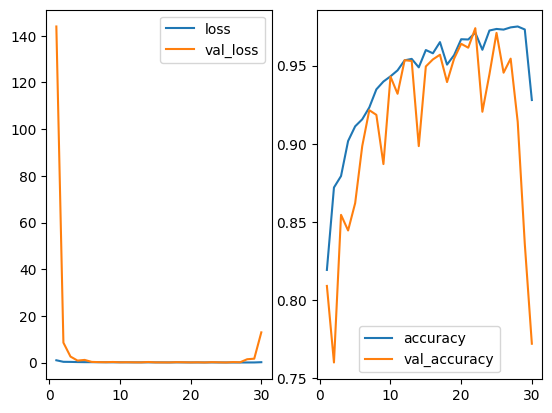

In [13]:
plt.subplot(1, 2, 1)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['loss'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_loss'][1:])
plt.legend(['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['accuracy'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_accuracy'][1:])
plt.legend(['accuracy', 'val_accuracy'])

In [14]:
cancer_model.save('models/inceptionV4_part2_3blocks.keras')

In [11]:
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

31/31 [==============================] - 124s 4s/step - loss: 2.6453 - accuracy: 0.6858


[2.6452794075012207, 0.6858009696006775]

# Testing Each cancer Type

In [3]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

2/2 [==============================] - 8s 3s/step - loss: 0.6256 - accuracy: 0.8176


[0.6255974173545837, 0.8175675868988037]

In [4]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

4/4 [==============================] - 17s 4s/step - loss: 0.9189 - accuracy: 0.7061


[0.9188759922981262, 0.7061144113540649]

In [5]:

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

2/2 [==============================] - 7s 3s/step - loss: 0.2396 - accuracy: 0.9051


[0.23955188691616058, 0.9050772786140442]

In [6]:

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

3/3 [==============================] - 9s 2s/step - loss: 2.3313 - accuracy: 0.6204


[2.33129620552063, 0.6203866600990295]

In [28]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

14/14 [==============================] - 77s 5s/step - loss: 5.2098 - accuracy: 0.5288


[5.209754467010498, 0.528832197189331]

In [29]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

3/3 [==============================] - 14s 4s/step - loss: 31.8637 - accuracy: 0.3323


[31.86374855041504, 0.3322683572769165]

In [30]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

4/4 [==============================] - 17s 4s/step - loss: 4.3312 - accuracy: 0.6174


[4.331207752227783, 0.6174242496490479]

In [31]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

3/3 [==============================] - 13s 3s/step - loss: 1.4325 - accuracy: 0.8054


[1.4324809312820435, 0.8053571581840515]

In [22]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

2/2 [==============================] - 5s 2s/step - loss: 0.5350 - accuracy: 0.8333


[0.5349516272544861, 0.8333333134651184]

In [23]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

4/4 [==============================] - 9s 2s/step - loss: 3.4997 - accuracy: 0.5187


[3.499666452407837, 0.5187376737594604]

In [26]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

2/2 [==============================] - 4s 2s/step - loss: 0.8169 - accuracy: 0.7991


[0.8168801069259644, 0.7991169691085815]

In [27]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

3/3 [==============================] - 5s 1s/step - loss: 4.2607 - accuracy: 0.6520


[4.2607011795043945, 0.6520211100578308]

In [32]:

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

14/14 [==============================] - 41s 3s/step - loss: 3.6851 - accuracy: 0.5671


[3.6850650310516357, 0.5670819878578186]

In [33]:

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

3/3 [==============================] - 7s 2s/step - loss: 16.0628 - accuracy: 0.3211


[16.062808990478516, 0.32108625769615173]

In [34]:

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

4/4 [==============================] - 9s 2s/step - loss: 2.9900 - accuracy: 0.5505


[2.9899954795837402, 0.5505050420761108]

In [35]:

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model.evaluate(images, labels, batch_size=256)

3/3 [==============================] - 6s 2s/step - loss: 1.1879 - accuracy: 0.7804


[1.1879111528396606, 0.7803571224212646]

# Træn på BreakHIS

In [37]:
images, labels = [], []
target_entries_per_type = 9000  
def load_images(path, label):
    global class_counts
    type_count = 0
    for cancerVariant in os.listdir(os.path.join(path)):
        for zoom in os.listdir(os.path.join(path,cancerVariant)):
            for image in os.listdir(os.path.join(path, cancerVariant, zoom)):
                img = cv2.imread(os.path.join(path, cancerVariant, zoom, image))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (192, 192))
                if img is not None:
                    images.append(img)
                    labels.append(label)
                    type_count += 1
                    if type_count == target_entries_per_type:
                        return

# Load benign images
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/"
load_images(pathBenign, 1)

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/"
load_images(pathBenign, 1)
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/"
load_images(pathBenign, 1)
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/"
load_images(pathBenign, 1)


# Load malignant images
pathMalignant = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/"
load_images(pathMalignant, 0)
pathMalignant = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/"
load_images(pathMalignant, 0)
pathMalignant = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/"
load_images(pathMalignant, 0)
pathMalignant = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/"
load_images(pathMalignant, 0)

In [38]:
print(len(labels))


7909


In [39]:
b, m = 0, 0
for _, elem in enumerate(labels):
    if elem == 0:
        m += 1
    else:
        b += 1
print(b, m)

2480 5429


In [7]:
images = np.array(images)
labels = np.array(labels)
x_train, x_test_val_data, y_train, y_test_val_data = train_test_split(images, labels, test_size = 0.4, random_state=42, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test_val_data, y_test_val_data, test_size = 0.5, random_state=69, shuffle=True)

In [8]:
x_train = x_train - np.mean(x_train, axis = 0)
x_train /= np.std(x_train, axis=0)

x_test = x_test - np.mean(x_test, axis=0)
x_test /= np.std(x_test, axis=0)

x_val = x_val - np.mean(x_val, axis=0)
x_val /= np.std(x_val, axis=0)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)
y_val = keras.utils.to_categorical(y_val, 2)

In [9]:

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by up to 20 degrees.
    width_shift_range=0.2,  # Randomly shift the width of the image.
    height_shift_range=0.2,  # Randomly shift the height of the image.
    shear_range=0.2,  # Apply shear transformation.
    zoom_range=0.2,  # Randomly zoom in/out.
    horizontal_flip=True,  # Randomly flip the image horizontally.
    vertical_flip=True,  # Randomly flip the image vertically.
    fill_mode='nearest'  # Fill in missing pixels using the nearest available value.
)
print(len(x_train))
augmented_images = []
augmented_labels = []

for i in range(len(x_train)//2):
    img = x_train[i]
    label = y_train[i]
    num_augmented_samples = 5

    for j in range(num_augmented_samples):
        augmented_img = datagen.random_transform(img)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Append the augmented data to the original data
x_train = np.append(x_train, augmented_images, axis=0)
y_train = np.append(y_train, augmented_labels, axis=0)


2112


In [10]:
#STEM Network
cancer_inception_inputs = layer.Input(shape=(192, 192,3))
conv1 = layer.Conv2D(64,(7,7),strides=2, padding="same", activation="elu")(cancer_inception_inputs)
bn1 = layer.BatchNormalization()(conv1)
mxPool1 = layer.MaxPool2D((3,3),strides=2)(bn1)
conv2 = layer.Conv2D(64, (1,1), activation="elu")(mxPool1)
bn2 = layer.BatchNormalization()(conv2)
conv3 = layer.Conv2D(192, (3,3), padding="same", activation="elu")(bn2)
bn3 = layer.BatchNormalization()(conv3)
mxPool2 = layer.MaxPool2D((3,3),strides=2, padding="same")(bn3)

#Inception Block
conv2_1 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
conv2_2 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
mxPool2_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(mxPool2)
bn2_1 = layer.BatchNormalization()(conv2_1)
bn2_2 = layer.BatchNormalization()(conv2_2)
# Second Layer in Inception Block
conv2_3 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2)
conv2_4 = layer.Conv2D(128,(3,3), padding="same", activation="elu")(bn2_1)
conv2_5 = layer.Conv2D(32, (5,5), padding = "same", activation="elu")(bn2_2)
conv2_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool2_1)
bn2_3 = layer.BatchNormalization()(conv2_3)
bn2_4 = layer.BatchNormalization()(conv2_4)
bn2_5 = layer.BatchNormalization()(conv2_5)
bn2_6 = layer.BatchNormalization()(conv2_6)
conc2 = layer.Concatenate()([bn2_3,bn2_4,bn2_5,bn2_6])

#Second Inception Block
conv3_1 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv3_2 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
mxPool3_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(conc2)
bn3_1 = layer.BatchNormalization()(conv3_1)
bn3_2 = layer.BatchNormalization()(conv3_2)
# Second Layer In Second Inception Block
conv3_3 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv3_4 = layer.Conv2D(192,(3,3), padding="same", activation="elu")(bn3_1)
conv3_5 = layer.Conv2D(64, (5,5), padding = "same", activation="elu")(bn3_2)
conv3_6 = layer.Conv2D(96,(1,1), activation="elu")(mxPool3_1)
bn3_3 = layer.BatchNormalization()(conv3_3)
bn3_4 = layer.BatchNormalization()(conv3_4)
bn3_5 = layer.BatchNormalization()(conv3_5)
bn3_6 = layer.BatchNormalization()(conv3_6)
conc3 = layer.Concatenate()([bn3_3,bn3_4,bn3_5,bn3_6])

gAvg = layer.AveragePooling2D((5,5), strides=3)(conc3)
conv4_1 = layer.Conv2D(128,(1,1), activation="elu")(gAvg)
bn4_1 = layer.BatchNormalization()(conv4_1)
net_out = layer.Flatten()(bn4_1)
fc1 = layer.Dense(1028, activation="elu")(net_out)
cancer_output = layer.Dense(2, activation="softmax")(fc1)

cancer_model = Model(cancer_inception_inputs, cancer_output)
cancer_model.compile(optimizer=opt.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
cancer_model_hist = cancer_model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=[callbakcs], verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
29/29 [==============================] - 259s 9s/step - loss: 35.7903 - accuracy: 0.6584 - val_loss: 1341.5939 - val_accuracy: 0.6037
Epoch 2/100
29/29 [==============================] - 235s 8s/step - loss: 3.9259 - accuracy: 0.7216 - val_loss: 58.9315 - val_accuracy: 0.6435
Epoch 3/100
29/29 [==============================] - 237s 8s/step - loss: 0.6406 - accuracy: 0.7858 - val_loss: 39.8652 - val_accuracy: 0.6136
Epoch 4/100
29/29 [==============================] - 235s 8s/step - loss: 0.7797 - accuracy: 0.7748 - val_loss: 27.1584 - val_accuracy: 0.6108
Epoch 5/100
29/29 [==============================] - 236s 8s/step - loss: 0.3846 - accuracy: 0.8286 - val_loss: 6.4130 - val_accuracy: 0.5256
Epoch 6/100
29/29 [==============================] - 232s 8s/step - loss: 0.3188 - accuracy: 0.8590 - val_loss: 3.8190 - val_accuracy: 0.5185
Epoch 7/100
29/29 [==============================] - 227s 8s/step - loss: 0.2648 - accuracy: 0.8877 - val_loss: 1.8473 - val_accuracy: 0.6335

In [12]:
score = cancer_model.evaluate(x_test, y_test, batch_size=256)
print(score[0])
print(score[1])

3/3 [==============================] - 5s 1s/step - loss: 0.2677 - accuracy: 0.8949
0.26765623688697815
0.8948863744735718


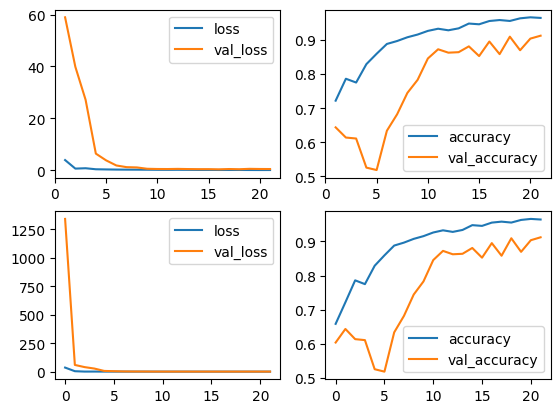

In [13]:
plt.subplot(2, 2, 1)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['loss'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_loss'][1:])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 2)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['accuracy'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_accuracy'][1:])
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(2, 2, 3)
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['loss'])
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 4)
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['accuracy'])
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [14]:
cancer_model.save('models/inceptionV6_breakhis.keras')

In [15]:
cancerModel1 = keras.models.load_model('models/inceptionV6_breakhis.keras')

checkpoint1 = 'concatenate'


#Inception Block
conv5_1 = keras.layers.Conv2D(160,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
conv5_2 = keras.layers.Conv2D(160,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
bn5_1 = layer.BatchNormalization()(conv5_1)
bn5_2 = layer.BatchNormalization()(conv5_2)
mxPool5_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(cancerModel1.get_layer(checkpoint1).output)
# Second Layer in Inception Block
conv5_3 = keras.layers.Conv2D(160,(1,1), activation="elu")(cancerModel1.get_layer(checkpoint1).output)
conv5_4 = layer.Conv2D(196,(3,3), padding="same", activation="elu")(bn5_1)
conv5_5 = layer.Conv2D(24, (5,5), padding = "same", activation="elu")(bn5_2)
conv5_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool5_1)
bn5_3 = layer.BatchNormalization()(conv5_3)
bn5_4 = layer.BatchNormalization()(conv5_4)
bn5_5 = layer.BatchNormalization()(conv5_5)
bn5_6 = layer.BatchNormalization()(conv5_6)
conc2 = layer.Concatenate()([bn5_3,bn5_4,bn5_5,bn5_6])

#Second Inception Block
conv6_1 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv6_2 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
mxPool6_1 = layer.MaxPool2D((3,3), strides=1, padding="same")(conc2)
bn6_1 = layer.BatchNormalization()(conv6_1)
bn6_2 = layer.BatchNormalization()(conv6_2)
# Second Layer In Second Inception Block
conv6_3 = layer.Conv2D(128,(1,1), activation="elu")(conc2)
conv6_4 = layer.Conv2D(256,(3,3), padding="same", activation="elu")(bn6_1)
conv6_5 = layer.Conv2D(24, (5,5), padding = "same", activation="elu")(bn6_2)
conv6_6 = layer.Conv2D(64,(1,1), activation="elu")(mxPool6_1)
bn6_3 = layer.BatchNormalization()(conv6_3)
bn6_4 = layer.BatchNormalization()(conv6_4)
bn6_5 = layer.BatchNormalization()(conv6_5)
bn6_6 = layer.BatchNormalization()(conv6_6)
conc3 = layer.Concatenate()([bn6_3,bn6_4,bn6_5,bn6_6])

conv7_1 = keras.layers.Conv2D(128,(1,1), activation="elu")(conc3)
conv7_2 = keras.layers.Conv2D(128,(1,1), activation="elu")(conc3)
bn7_1 = layer.BatchNormalization()(conv7_1)
bn7_2 = layer.BatchNormalization()(conv7_2)
mxPool7_1 = keras.layers.MaxPool2D((3,3), strides=1, padding="same")(conc3)

# Second Layer in Third Inception Block
conv7_3 = keras.layers.Conv2D(128,(1,1), activation="elu")(conc3)
conv7_4 = keras.layers.Conv2D(256,(3,3), padding="same", activation="elu")(bn7_1)
conv7_5 = keras.layers.Conv2D(24, (5,5), padding = "same", activation="elu")(bn7_2)
conv7_6 = keras.layers.Conv2D(64,(1,1), activation="elu")(mxPool7_1)
bn7_3 = layer.BatchNormalization()(conv7_3)
bn7_4 = layer.BatchNormalization()(conv7_4)
bn7_5 = layer.BatchNormalization()(conv7_5)
bn7_6 = layer.BatchNormalization()(conv7_6)
conc4 = keras.layers.Concatenate()([bn7_3,bn7_4,bn7_5,bn7_6])

gAvg = layer.AveragePooling2D((5,5), strides=3)(conc4)
conv8_1 = layer.Conv2D(128,(1,1), activation="elu")(gAvg)
bn8_1 = layer.BatchNormalization()(conv8_1)
net_out = layer.Flatten()(bn8_1)
fc1 = layer.Dense(1028, activation="elu")(net_out)
cancer_output = layer.Dense(2, activation="softmax")(fc1)

cancer_model1 = Model(inputs=cancerModel1.input, outputs=cancer_output)
cancer_model1.compile(optimizer=opt.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
cancer_model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [16]:
cancer_model_hist = cancer_model1.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=[callbakcs], verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
29/29 [==============================] - 399s 14s/step - loss: 39.2794 - accuracy: 0.6433 - val_loss: 2197.5618 - val_accuracy: 0.7642
Epoch 2/100
29/29 [==============================] - 392s 14s/step - loss: 3.4424 - accuracy: 0.7198 - val_loss: 133.9454 - val_accuracy: 0.7457
Epoch 3/100
29/29 [==============================] - 402s 14s/step - loss: 0.9995 - accuracy: 0.7215 - val_loss: 5.9330 - val_accuracy: 0.6605
Epoch 4/100
29/29 [==============================] - 403s 14s/step - loss: 0.5441 - accuracy: 0.7756 - val_loss: 3.9576 - val_accuracy: 0.7855
Epoch 5/100
29/29 [==============================] - 397s 14s/step - loss: 0.7542 - accuracy: 0.7861 - val_loss: 4.3331 - val_accuracy: 0.5994
Epoch 6/100
29/29 [==============================] - 396s 14s/step - loss: 1.0008 - accuracy: 0.7462 - val_loss: 1.0193 - val_accuracy: 0.7585
Epoch 7/100
29/29 [==============================] - 397s 14s/step - loss: 0.5145 - accuracy: 0.8071 - val_loss: 0.4919 - val_accuracy: 

In [17]:
score = cancer_model1.evaluate(x_test, y_test, batch_size=256)
print(score[0])
print(score[1])

3/3 [==============================] - 8s 2s/step - loss: 0.3364 - accuracy: 0.9020
0.33643263578414917
0.9019886255264282


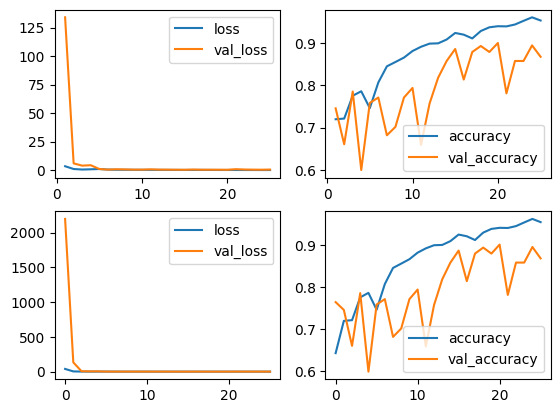

In [18]:
plt.subplot(2, 2, 1)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['loss'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_loss'][1:])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 2)
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['accuracy'][1:])
plt.plot(cancer_model_hist.epoch[1:], cancer_model_hist.history['val_accuracy'][1:])
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(2, 2, 3)
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['loss'])
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.subplot(2, 2, 4)
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['accuracy'])
plt.plot(cancer_model_hist.epoch, cancer_model_hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [19]:
cancer_model1.save('models/inceptionV6_part2_breakhis.keras')

In [24]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis"

images_1,images_2, images, labels = [], [], [],[]
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("adenosis")
print(model.evaluate(images, labels, batch_size=256))



pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma"

images_1,images_2, images, labels = [], [], [],[]
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("fibroadenoma")
print(model.evaluate(images, labels, batch_size=256))

pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor"

images_1,images_2, images, labels = [], [], [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("phyllodes tumor")
print(model.evaluate(images, labels, batch_size=256))
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma"

images_1,images_2, images, labels = [], [], [],[]
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(1)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("tubular adenoma")
print(model.evaluate(images, labels, batch_size=256))


adenosis
2/2 [==============================] - 3s 1s/step - loss: 0.8796 - accuracy: 0.7995
[0.8795595765113831, 0.7995495200157166]
fibroadenoma
4/4 [==============================] - 7s 2s/step - loss: 1.4531 - accuracy: 0.6075
[1.453084945678711, 0.6074950695037842]
phyllodes tumor
2/2 [==============================] - 3s 1s/step - loss: 1.5298 - accuracy: 0.6247
[1.5298124551773071, 0.6247240900993347]
tubular adenoma
3/3 [==============================] - 4s 1s/step - loss: 0.8307 - accuracy: 0.6924
[0.8307194113731384, 0.6924428939819336]


In [25]:
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("ductal carcinoma")
print(model.evaluate(images, labels, batch_size=256))
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("lobular carcinoma")
print(model.evaluate(images, labels, batch_size=256))
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma"

images, labels = [], []
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("mucinous carcinoma")
print(model.evaluate(images, labels, batch_size=256))
pathBenign = "data/BreakHIS/breakhis/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma"

images_1,images_2, images, labels = [], [], [],[]
for cancerVariant in os.listdir(pathBenign):
    for zoom in os.listdir(pathBenign+"/"+cancerVariant):
        for image in os.listdir(pathBenign +"/"+cancerVariant + "/" + zoom):
            img = cv2.imread(os.path.join(pathBenign + "/" + cancerVariant + "/" + zoom, image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (192, 192))
            if img is not None:
                images.append(img)
                labels.append(0)
images_1 = images[:len(images)//2]
images_2 = images[len(images)//2:]
# Preprocessing:
# normalize input
images_1 = images_1 - np.mean(images_1, axis = 0)
images_1 /= np.std(images_1, axis=0)

images_2 = images_2 - np.mean(images_2, axis = 0)
images_2 /= np.std(images_2, axis=0)

labels = keras.utils.to_categorical(labels, 2)
images = np.concatenate((images_1, images_2), axis=0)
model = keras.models.load_model('models/inceptionV6_breakhis.keras')
print("papillary carcinoma")
print(model.evaluate(images, labels, batch_size=256))

ductal carcinoma
14/14 [==============================] - 24s 2s/step - loss: 5.9381 - accuracy: 0.3732
[5.9381489753723145, 0.3732251524925232]
lobular carcinoma
3/3 [==============================] - 5s 1s/step - loss: 10.1649 - accuracy: 0.2955
[10.164902687072754, 0.2955271601676941]
mucinous carcinoma
4/4 [==============================] - 6s 1s/step - loss: 4.6810 - accuracy: 0.4470
[4.681044578552246, 0.4469696879386902]
papillary carcinoma
3/3 [==============================] - 4s 1s/step - loss: 1.7553 - accuracy: 0.7804
[1.7552740573883057, 0.7803571224212646]


# Evaluation of the models

In [19]:
model1 = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model2 = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)
print(pred1[:10])

63/63 [==============================] - 35s 551ms/step
[[8.9115332e-05 9.9991083e-01]
 [1.0000000e+00 7.5057978e-09]
 [1.0000000e+00 0.0000000e+00]
 [9.9908698e-01 9.1300206e-04]
 [3.5425108e-02 9.6457493e-01]
 [9.9988413e-01 1.1587624e-04]
 [1.0000000e+00 2.3103687e-28]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [7.3725417e-02 9.2627454e-01]]


In [20]:
bin_pred1 = (np.argmax(pred1, axis=1) > 0.5).astype(int)
bin_pred2 = (np.argmax(pred2, axis=1) > 0.5).astype(int)

In [21]:
y_val = np.argmax(y_val, axis=1)

In [22]:

b_acc1 = balanced_accuracy_score(y_val, bin_pred1)
b_acc2 = balanced_accuracy_score(y_val, bin_pred2)
print(f"Balanced Accuracy Score for model 1: {b_acc1}")
print(f"Balanced Accuracy Score for model 2: {b_acc2}")

Balanced Accuracy Score for model 1: 0.9704717617940448
Balanced Accuracy Score for model 2: 0.970979274481862


In [23]:
# Lets confuse these hoes
cm1 = confusion_matrix(y_val, bin_pred1)
cm2 = confusion_matrix(y_val, bin_pred2)
disp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["Benign","Malignant"])
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["Benign","Malignant"])

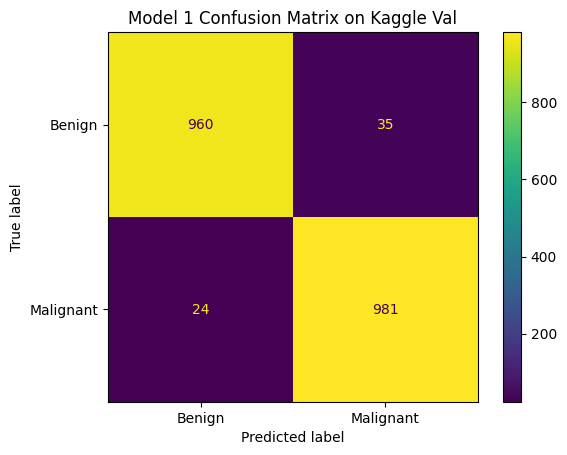

In [24]:
disp1.plot()
plt.title("Model 1 Confusion Matrix on Kaggle Val")
plt.show()

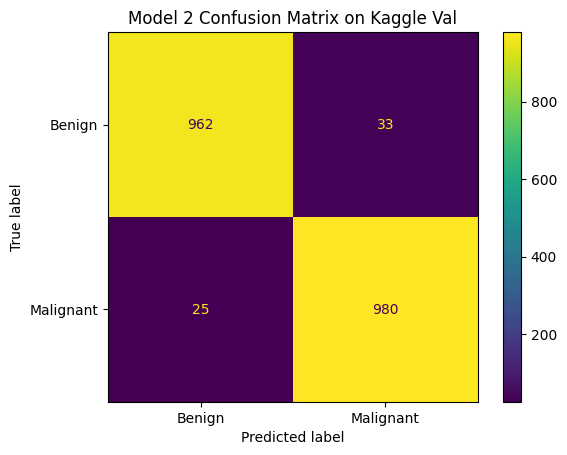

In [25]:
disp2.plot()
plt.title("Model 2 Confusion Matrix on Kaggle Val")
plt.show()

# Evaluation on BreakHIS

In [35]:
model1 = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model2 = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
pred1 = model1.predict(images)
pred2 = model2.predict(images)
print(pred1[:10])

248/248 [==============================] - 140s 562ms/step
[[4.0329836e-04 9.9959677e-01]
 [6.8404738e-06 9.9999321e-01]
 [1.6720103e-06 9.9999833e-01]
 [3.5737910e-10 1.0000000e+00]
 [5.5844441e-05 9.9994421e-01]
 [8.0626190e-04 9.9919373e-01]
 [8.8454235e-01 1.1545759e-01]
 [9.9706709e-02 9.0029329e-01]
 [1.1533508e-01 8.8466495e-01]
 [3.9701998e-05 9.9996030e-01]]


In [36]:
bin_pred1 = (np.argmax(pred1, axis=1) > 0.5).astype(int)
bin_pred2 = (np.argmax(pred2, axis=1) > 0.5).astype(int)
y_val = np.argmax(labels, axis=1)
b_acc1 = balanced_accuracy_score(y_val, bin_pred1)
b_acc2 = balanced_accuracy_score(y_val, bin_pred2)
print(f"Balanced Accuracy Score for model 1: {b_acc1}")
print(f"Balanced Accuracy Score for model 2: {b_acc2}")

Balanced Accuracy Score for model 1: 0.7224997251914747
Balanced Accuracy Score for model 2: 0.7204310854491114


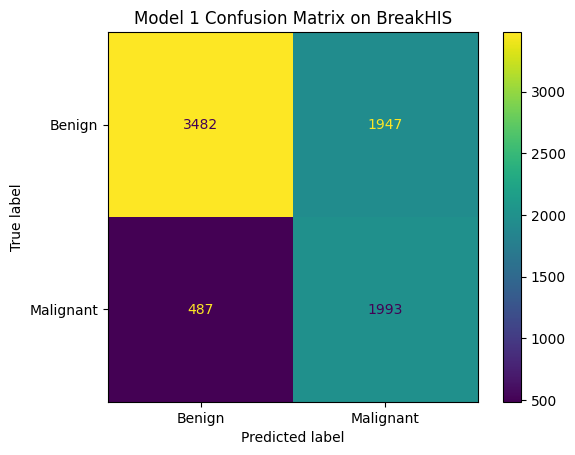

In [37]:
cm1 = confusion_matrix(y_val, bin_pred1)
cm2 = confusion_matrix(y_val, bin_pred2)
disp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["Benign","Malignant"])
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["Benign","Malignant"])
disp1.plot()
plt.title("Model 1 Confusion Matrix on BreakHIS")
plt.show()

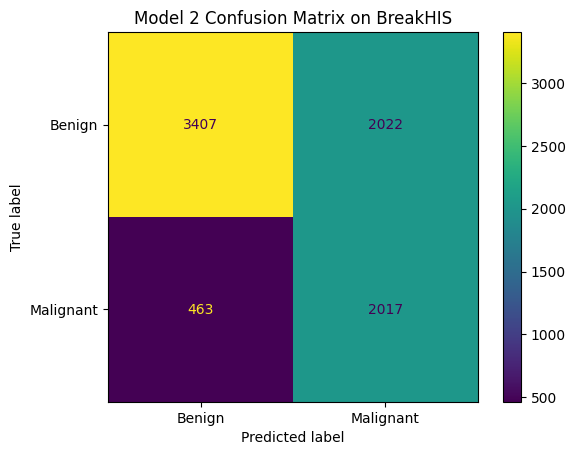

In [38]:
disp2.plot()
plt.title("Model 2 Confusion Matrix on BreakHIS")
plt.show()

# CNN Heatmap

In [2]:
model1 = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model2 = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [3]:
conv_output1 = model1.get_layer("concatenate_2").output
pred_ouptut1 = model1.get_layer("dense_1").output
m1 = Model(model1.input, outputs=[conv_output1, pred_ouptut1])

In [4]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [5]:
conv_output2 = model2.get_layer("concatenate_8").output
pred_ouptut2 = model2.get_layer("dense_5").output
m2 = Model(model2.input, outputs=[conv_output2, pred_ouptut2])

In [8]:
pathBreast = "data/Multi Cancer/Breast Cancer/breast_benign/breast_benign_0001.jpg"
img = cv2.imread(pathBreast)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (192, 192))

In [15]:
x_val = img + x_val
conv, pred = m1.predict(x_val)
conv1 = conv[0]
pred1 = pred[0]
conv, pred = m2.predict(x_val)
conv2 = conv[0]
pred2 = pred[0]

63/63 [==============================] - 33s 521ms/step


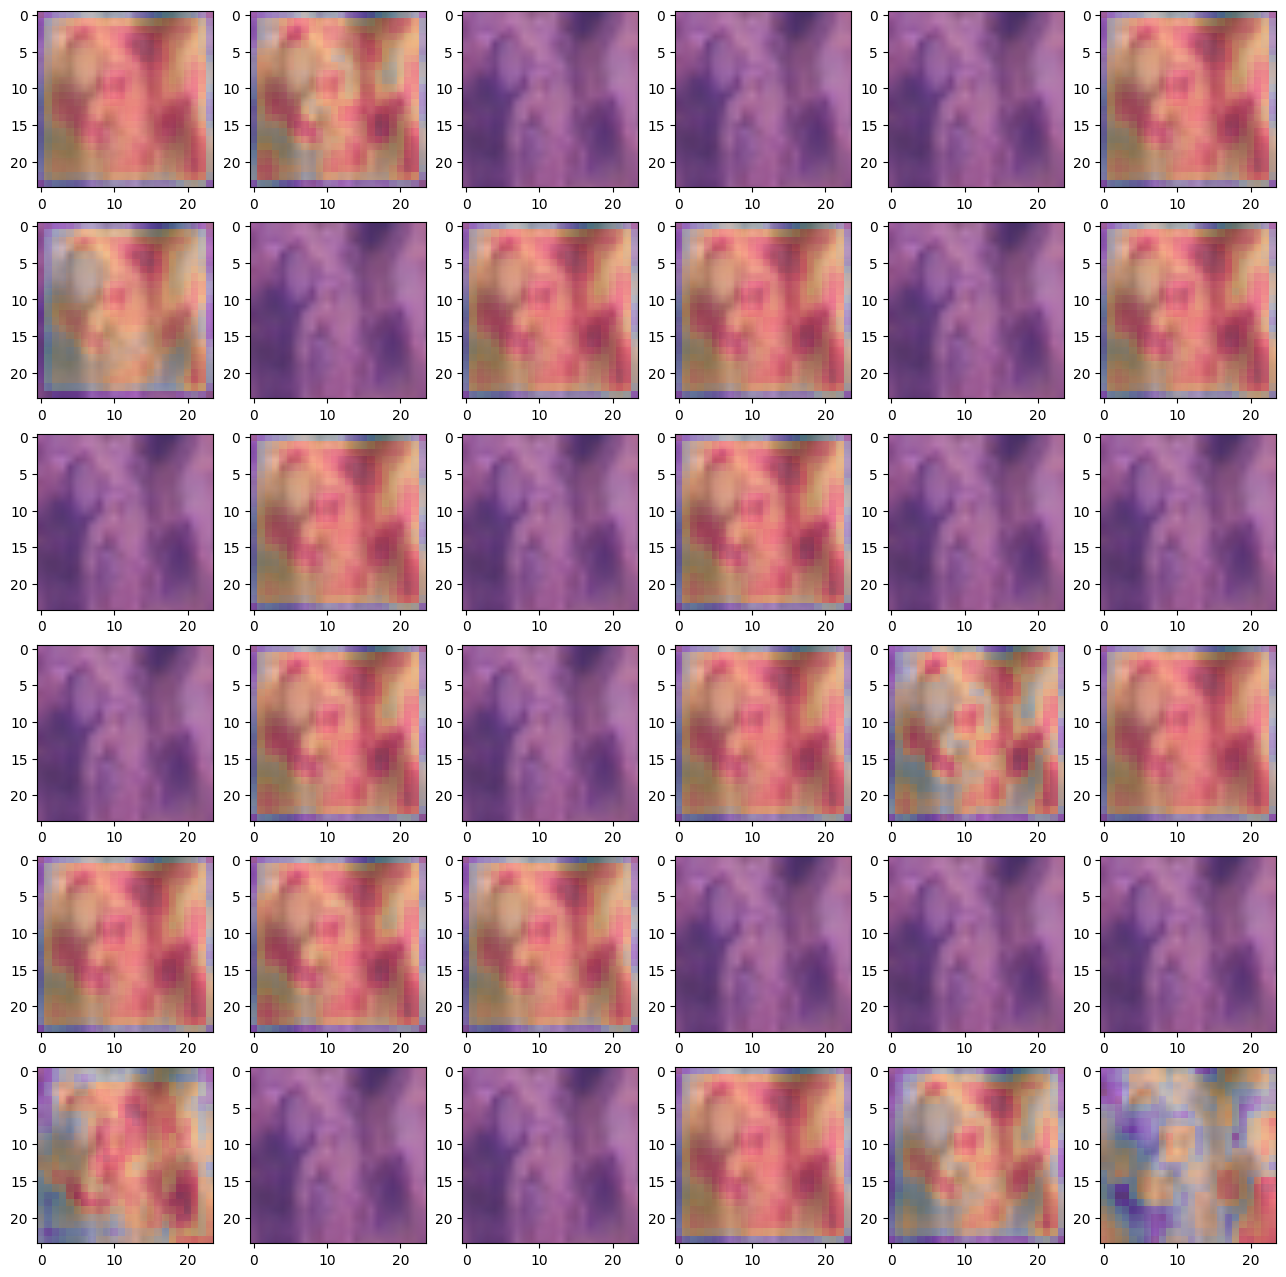

In [26]:
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img, interpolation="bilinear")
    plt.imshow(conv1[:, :, i], cmap='jet', alpha=0.25)

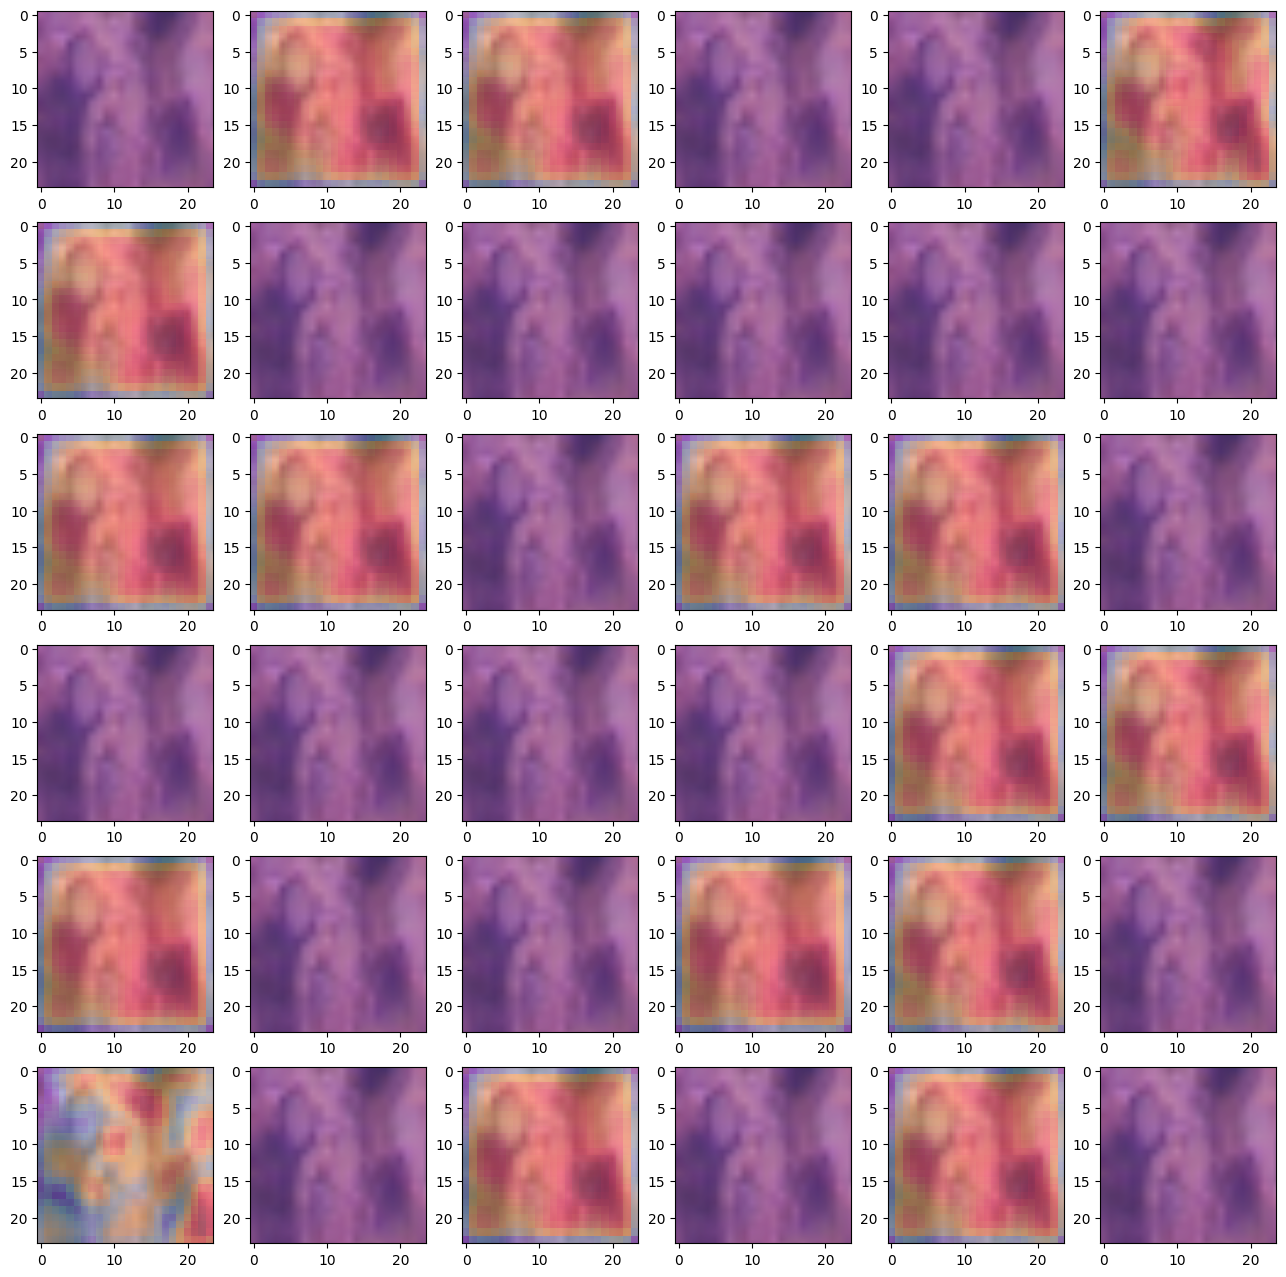

In [27]:
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img, interpolation="bilinear")
    plt.imshow(conv2[:, :, i], cmap='jet', alpha=0.25)

# F1-Score

In [36]:
model1 = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model2 = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)
#print(pred1[:10])
bin_pred1 = (np.argmax(pred1, axis=1) > 0.5).astype(int)
bin_pred2 = (np.argmax(pred2, axis=1) > 0.5).astype(int)
y_val = np.argmax(y_val, axis=1)
b_acc1 = f1_score(y_val, bin_pred1)
b_acc2 = f1_score(y_val, bin_pred2)
print(f"F1 Score for model 1: {b_acc1}")
print(f"F1 Score for model 2: {b_acc2}")

63/63 [==============================] - 34s 536ms/step
[[8.9115332e-05 9.9991083e-01]
 [1.0000000e+00 7.5057978e-09]
 [1.0000000e+00 0.0000000e+00]
 [9.9908698e-01 9.1300206e-04]
 [3.5425108e-02 9.6457493e-01]
 [9.9988413e-01 1.1587624e-04]
 [1.0000000e+00 2.3103687e-28]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [7.3725417e-02 9.2627454e-01]]
Balanced Accuracy Score for model 1: 0.970806531420089
Balanced Accuracy Score for model 2: 0.9712586719524282


In [41]:
images = np.array(images)
labels = np.array(labels)
model1 = keras.models.load_model('models/inceptionV4_part1_3blocks.keras')
model2 = keras.models.load_model('models/inceptionV4_part2_3blocks.keras')
pred1 = model1.predict(images)
pred2 = model2.predict(images)
#print(pred1[:10])
bin_pred1 = (np.argmax(pred1, axis=1) > 0.5).astype(int)
bin_pred2 = (np.argmax(pred2, axis=1) > 0.5).astype(int)
y_val = labels
b_acc1 = f1_score(y_val, bin_pred1)
b_acc2 = f1_score(y_val, bin_pred2)
print(f"F1 Score for model 1: {b_acc1}")
print(f"F1 Score for model 2: {b_acc2}")

248/248 [==============================] - 130s 523ms/step
F1 Score for model 1: 0.47742804889787277
F1 Score for model 2: 0.47742804889787277
